In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, normalize_matrix, moca


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

# df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-09 11:56:08.499988,151.320299,-33.889224,NaN,0.005571,0.025212,-0.104460,0.036320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-09 12:13:38.666652,151.336628,-33.915619,NaN,-0.007718,0.051367,0.266196,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-09 12:26:08.500002,151.372994,-33.939047,NaN,-0.006178,-0.001007,0.025207,0.039912,0.058620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-09 12:43:38.666665,151.426511,-33.973251,NaN,-0.040717,0.011668,0.069795,0.072353,0.056161,0.063086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-09 12:56:08.749984,151.464043,-33.998656,NaN,-0.054494,-0.046787,0.008042,0.045238,0.037273,0.037848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-11-01 03:40:29.666685,152.133657,-33.499170,NaN,-0.193570,-0.174856,-0.137530,-0.129104,-0.171884,-0.182623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2170,2023-11-01 03:55:29.333340,152.162703,-33.499744,NaN,-0.265587,-0.234279,-0.260916,-0.220431,-0.168265,-0.207625,...,0.099449,0.131495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,2023-11-01 04:10:29.666658,152.191377,-33.499695,NaN,-0.273816,-0.266387,-0.292629,-0.261923,-0.164615,-0.147517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,2023-11-01 04:25:29.333353,152.220223,-33.499658,NaN,-0.283102,-0.277454,-0.314878,-0.320812,-0.254559,-0.195608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### SWOT Data

In [4]:
lon0, lon1 = 153, 156
lat0, lat1 = -39, -37
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


(-39.0, -37.0)

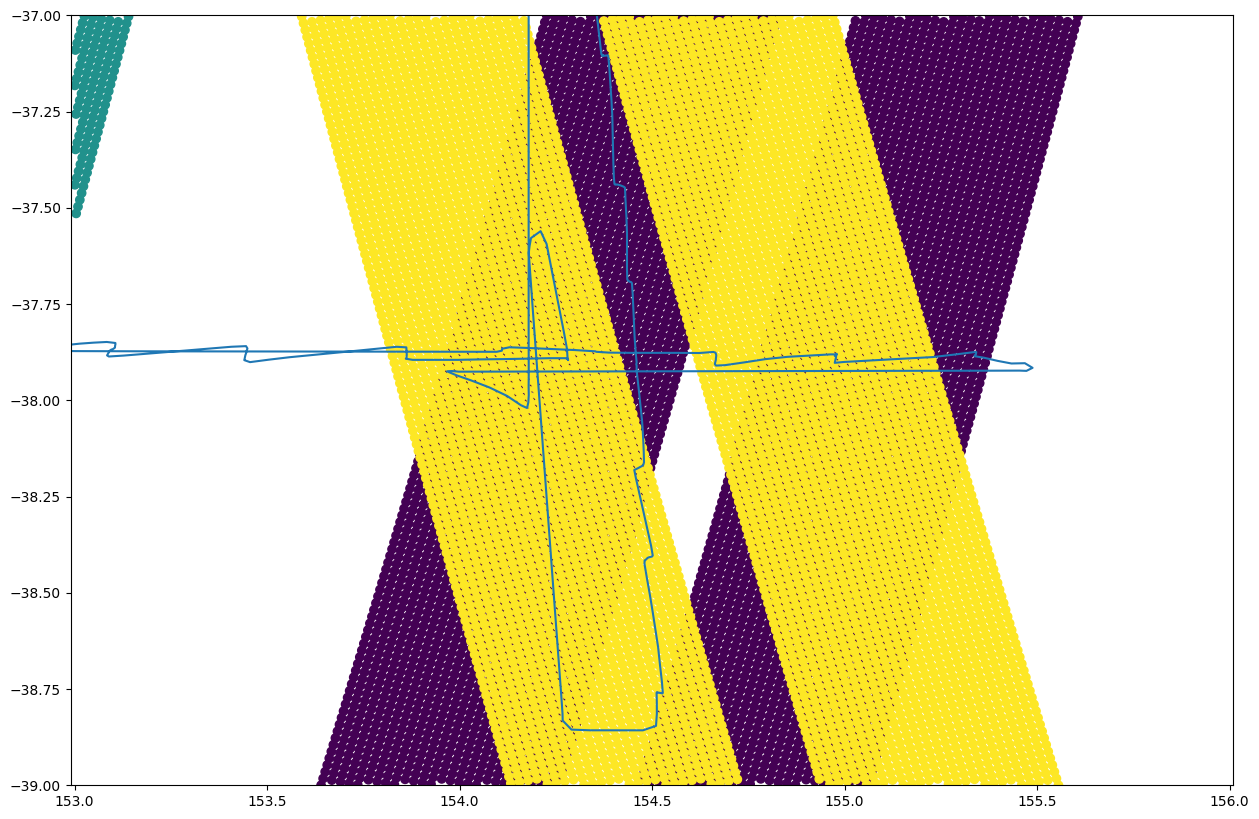

In [5]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot= df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= tim0) & (df.Time <= tim1)]

plt.figure(figsize=(15,10))
plt.scatter(df_CE.Lon, df_CE.Lat, c=df_CE.ID)
plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


#### ESPRA App. 1

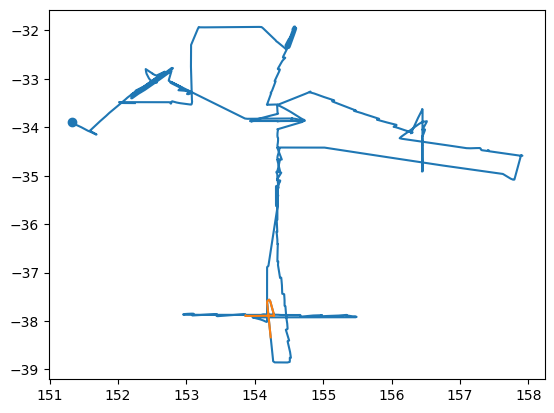

In [6]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t1 = pd.Timestamp('2023-10-19 5:00:00')
days1 = .3
df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))]
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [7]:
df_results1 = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
us = [col for col in df1.columns if col.startswith('u_')]
vs = [col for col in df1.columns if col.startswith('v_')]
for (u_idx, v_idx) in zip(us, vs):
    ui, vi = df1[u_idx], df1[v_idx]
    xi, yi = df1.Lon, df1.Lat

    df_clean1 = pd.DataFrame({'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi})
    df_clean1 = df_clean1.dropna()

    if len(df_clean1):
        xc, yc, w, Q, Rc, psi0 = espra(df_clean1.xi, df_clean1.yi, df_clean1.ui, df_clean1.vi, Rc_max=50)
        df_results1.loc[len(df_results1)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Depth': int(u_idx[2:])}
        

In [8]:
# find & sort your u_/v_ columns by the number after the underscore
import re

def depth_key(col):
    # assumes columns like 'u_10', 'v_219', etc.
    return int(re.split(r'u_|v_', col)[1])

u_cols = sorted([c for c in df1.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df1.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df1[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col],
        Rc_max=1,
        flag_km=False
    )
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results1 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results1 = df_results1[df_results1['Depth'] <= 680]
df_results1 = df_results1.reset_index().drop(columns=['index'])


In [9]:
df_results1


,xc,yc,w,Q,Rc,psi0,Depth
0,154.345586,-37.923586,-3.501609,"[[-0.8469194101978027, -0.02526943043219398], ...",0.828857,0.748594,37
1,154.351620,-37.917914,-3.433401,"[[-0.8220455325771786, -0.012342772674778676],...",0.861837,0.803656,47
2,154.362663,-37.909006,-3.333933,"[[-0.7856933022073451, 0.0056177403002952864],...",0.866945,0.812203,57
3,154.370480,-37.901684,-3.182035,"[[-0.7378411718025264, 0.014601841387943008], ...",0.860609,0.799514,67
4,154.384322,-37.891320,-2.978204,"[[-0.6643711220315979, 0.024374940776905715], ...",0.824083,0.736107,77
...,...,...,...,...,...,...,...
60,154.392069,-37.897263,-2.294467,"[[-0.4334472721290313, -0.018776200431432], [-...",0.926110,0.904306,637
61,154.399649,-37.894515,-2.286480,"[[-0.4247142692417963, -0.0016952917171243458]...",0.912581,0.879915,647
62,154.406119,-37.889401,-2.250404,"[[-0.4120245348926238, 0.009864800589830948], ...",0.942719,0.935642,657
63,154.404989,-37.875311,-2.290018,"[[-0.43022589242600207, 0.038610288480247515],...",0.906766,0.873312,667


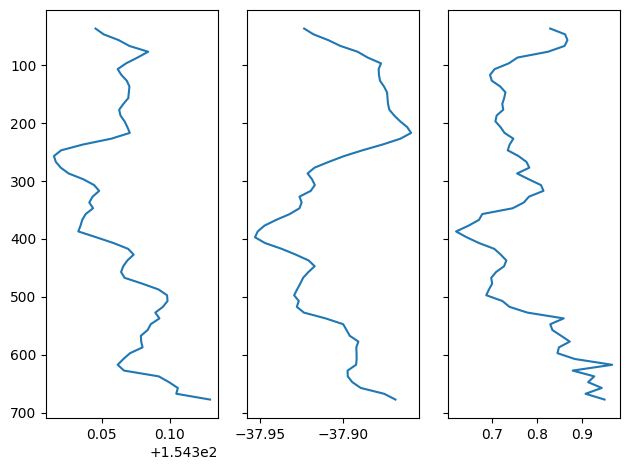

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True)
mask = df_results1.Depth <= 680
axs[0].plot(df_results1.xc[mask], df_results1.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results1.yc[mask], df_results1.Depth[mask])
axs[2].plot(df_results1.Rc[mask], df_results1.Depth[mask])
plt.tight_layout()

#### ESPRA App. 2

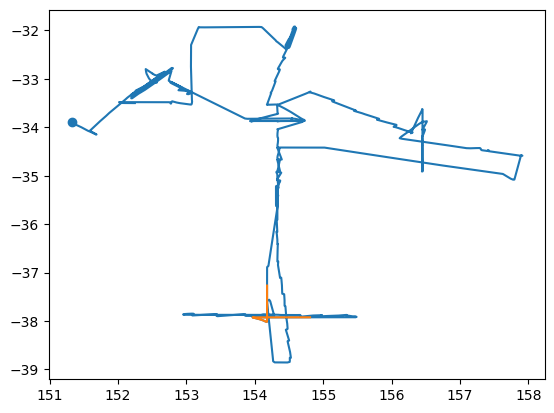

In [11]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t2 = pd.Timestamp('2023-10-21 13:30:00')
days2 = .3
df2 = df_sadcp[(df_sadcp.Time >= t2 - pd.Timedelta(days=days2)) & (df_sadcp.Time <= t2 + pd.Timedelta(days=days2))].copy()
plt.plot(df2.Lon, df2.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [12]:
u_cols = sorted([c for c in df2.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df2.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df2[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col],
        Rc_max=1,
        flag_km=False
    )
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results2 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results2 = df_results2[df_results2['Depth'] <= 680]
df_results2 = df_results2.reset_index().drop(columns=['index'])


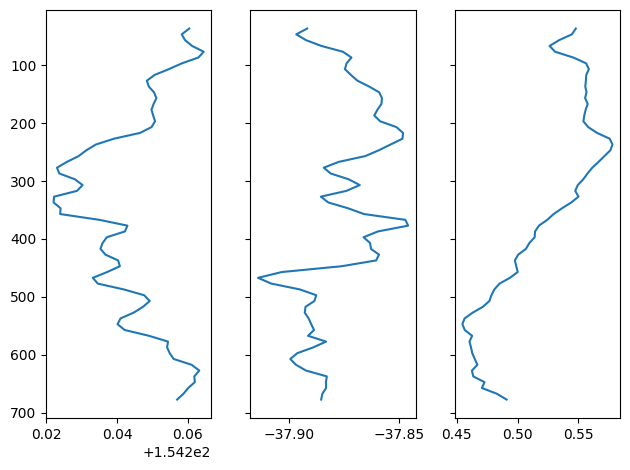

In [13]:
fig, axs = plt.subplots(1, 3, sharey=True)
mask = df_results2.Depth <= 680
axs[0].plot(df_results2.xc[mask], df_results2.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results2.yc[mask], df_results2.Depth[mask])
axs[2].plot(df_results2.Rc[mask], df_results2.Depth[mask])
plt.tight_layout()


In [14]:
df_results2

,xc,yc,w,Q,Rc,psi0,Depth
0,154.260387,-37.891858,-2.845251,"[[-0.8514094446398511, 0.06787003483891164], [...",0.547912,0.393247,37
1,154.258241,-37.896840,-2.818079,"[[-0.845664697003091, 0.06365520761252139], [0...",0.544660,0.390188,47
2,154.259191,-37.892383,-2.812725,"[[-0.841401564135764, 0.06023287541182498], [0...",0.534156,0.378636,57
3,154.261170,-37.885360,-2.799366,"[[-0.8372348593143267, 0.06184733541478809], [...",0.526307,0.368697,67
4,154.264463,-37.875543,-2.769732,"[[-0.8292237253737494, 0.07435031384928717], [...",0.530854,0.369648,77
...,...,...,...,...,...,...,...
60,154.261794,-37.882898,-1.929909,"[[-0.5542728842479906, 0.05392435455856906], [...",0.463437,0.281071,637
61,154.261947,-37.883287,-1.885901,"[[-0.5468326262671065, 0.06658866231141587], [...",0.472738,0.287542,647
62,154.260083,-37.883211,-1.853060,"[[-0.5371337279591483, 0.07446101461825519], [...",0.470526,0.285214,657
63,154.258730,-37.884926,-1.819412,"[[-0.5308161590752063, 0.07681918010297677], [...",0.482871,0.295615,667


#### Test App

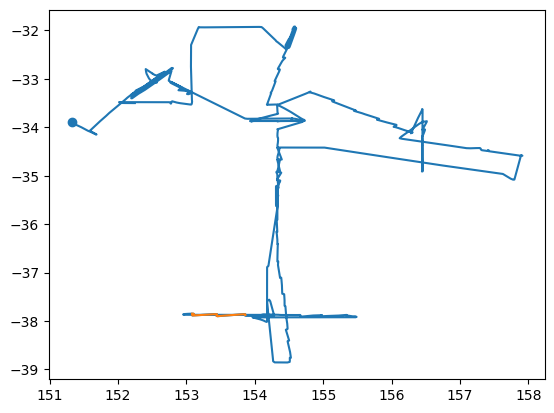

In [15]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t3 = pd.Timestamp('2023-10-19 18:00:00')
days3 = .2
df3 = df_sadcp[(df_sadcp.Time >= t3 - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t3 + pd.Timedelta(days=days3))].copy()
plt.plot(df3.Lon, df3.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

lon0, lon1 = 153, 156
lat0, lat1 = -39, -36


In [16]:
df = df_sadcp.copy()
df = df[(df.Lon >= lon0) & (df.Lon <= lon1) & (df.Lat >= lat0) & (df.Lat <= lat1)]

tim0 = df.iloc[0].Time
tim1 = df.iloc[-1].Time
print(tim0, tim1)


2023-10-16 17:12:30.333340 2023-10-22 05:57:30.333340


### Reconstruction

In [17]:
def calc_ow(u, v, dx, dy):
    dudy, dudx = np.gradient(u, dy, dx)
    dvdy, dvdx = np.gradient(v, dy, dx)
    
    # normal strain, shear strain, vorticity
    S_n   = dudx - dvdy
    S_s   = dvdx + dudy
    omega = dvdx - dudy
    
    # Okubo–Weiss parameter
    OW = S_n**2 + S_s**2 - omega**2
    return OW
    

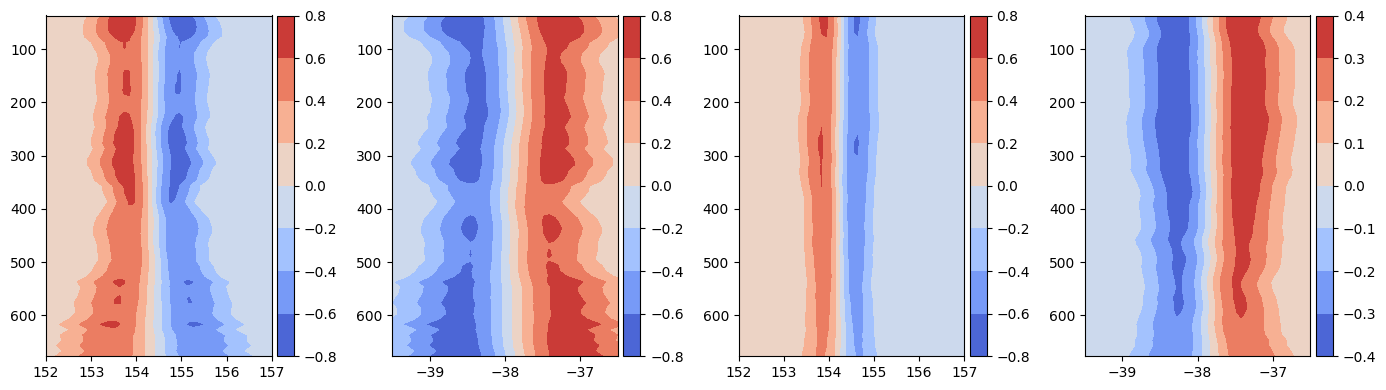

In [18]:
x, y = np.linspace(152, 157, 50), np.linspace(-39.5, -36.5, 50)
X, Y = np.meshgrid(x, y)
dx, dy = x[1]-x[0], y[1]-y[0]
dx_m, dy_m = dx * np.cos(np.deg2rad(np.mean(y))) * 111000, dy * np.cos(np.deg2rad(np.mean(y))) * 111000

U1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
V1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
OW1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
for k in range(len(df_results1)):
    data = df_results1.iloc[k]
    xc, yc, Q11, Q12, Q22, Rc, psi0 = data.xc, data.yc, data.Q[0,0], data.Q[1,0], data.Q[1,1], data.Rc, data.psi0
    u1, v1, *_ = gaussian_vel_reconstruction(xc, yc, Q11, Q12, Q22, Rc, psi0, X, Y)
    U1[:,:,k] = u1
    V1[:,:,k] = v1
    OW1[:,:,k] = calc_ow(u1, v1, dx_m, dy_m).T
OW1 = normalize_matrix(OW1)

U2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
V2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
OW2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
for k in range(len(df_results2)):
    data = df_results2.iloc[k]
    xc, yc, Q11, Q12, Q22, Rc, psi0 = data.xc, data.yc, data.Q[0,0], data.Q[1,0], data.Q[1,1], data.Rc, data.psi0
    u2, v2, *_ = gaussian_vel_reconstruction(xc, yc, Q11, Q12, Q22, Rc, psi0, X, Y)
    U2[:,:,k] = u2
    V2[:,:,k] = v2
    OW2[:,:,k] = calc_ow(u2, v2, dx_m, dy_m).T
OW2 = normalize_matrix(OW2)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
# draw and store each contourf
cf0 = axs[0].contourf(x, df_results1.Depth, V1[V1.shape[0]//2, :, :].T, cmap='coolwarm')
axs[0].invert_yaxis()

cf1 = axs[1].contourf(y, df_results1.Depth, U1[:, U1.shape[1]//2, :].T, cmap='coolwarm')
axs[1].invert_yaxis()

cf2 = axs[2].contourf(x, df_results2.Depth, V2[V2.shape[0]//2, :, :].T, cmap='coolwarm')
axs[2].invert_yaxis()

cf3 = axs[3].contourf(y, df_results2.Depth, U2[:, U2.shape[1]//2, :].T, cmap='coolwarm')
axs[3].invert_yaxis()

# attach one colourbar per axis
for ax, cf in zip(axs, (cf0, cf1, cf2, cf3)):
    fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


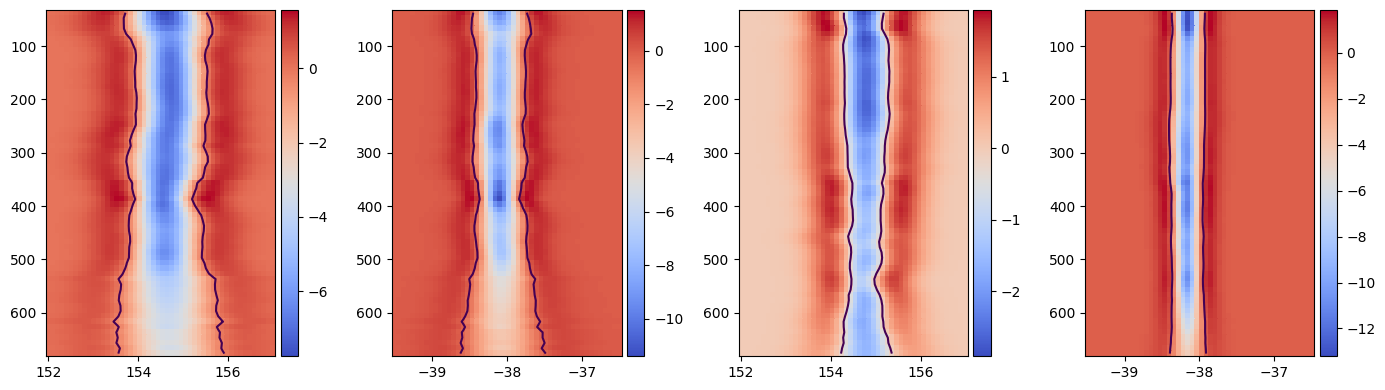

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
# draw and store each contourf
cf0 = axs[0].pcolor(x, df_results1.Depth, OW1[OW1.shape[0]//2, :, :].T, cmap='coolwarm')
axs[0].contour(x, df_results1.Depth, OW1[OW1.shape[0]//2, :, :].T, levels=[-.2])
axs[0].invert_yaxis()

cf1 = axs[1].pcolor(y, df_results1.Depth, OW1[:, OW1.shape[1]//2, :].T, cmap='coolwarm')
axs[1].contour(y, df_results1.Depth, OW1[:, OW1.shape[1]//2, :].T, levels=[-.2])
axs[1].invert_yaxis()

cf2 = axs[2].pcolor(x, df_results2.Depth, OW2[OW2.shape[0]//2, :, :].T, cmap='coolwarm')
axs[2].contour(x, df_results2.Depth, OW2[OW2.shape[0]//2, :, :].T, levels=[-.2])
axs[2].invert_yaxis()

cf3 = axs[3].pcolor(y, df_results2.Depth, OW2[:, OW2.shape[1]//2, :].T, cmap='coolwarm')
axs[3].contour(y, df_results2.Depth, OW2[:, OW2.shape[1]//2, :].T, levels=[-.2])
axs[3].invert_yaxis()

# attach one colourbar per axis
for ax, cf in zip(axs, (cf0, cf1, cf2, cf3)):
    fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


### Case 1 Analysis

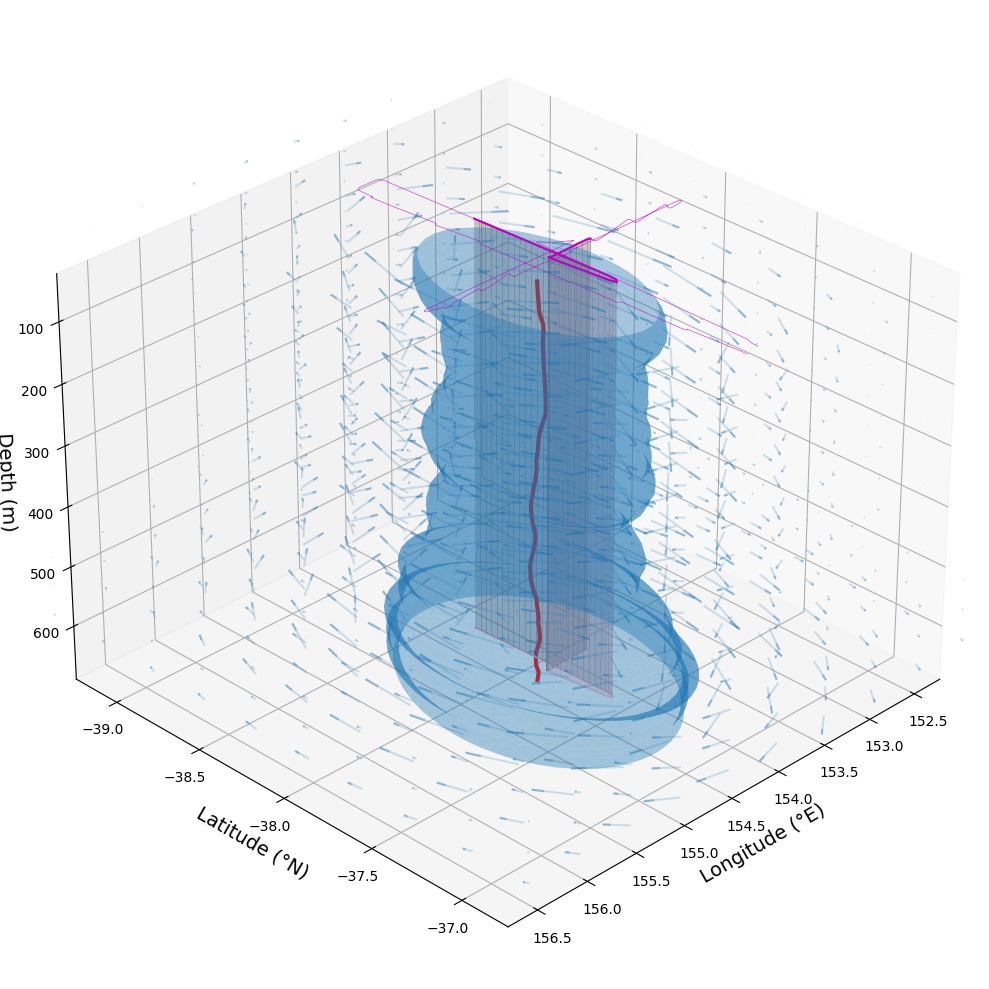

In [20]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# volume.shape == (nz, ny, nx); X.shape == (ny, nx); Y.shape == (ny, nx); z.shape == (nz,)

z = df_results1.Depth.values
dz = z[1] - z[0]

verts, faces, normals, values = measure.marching_cubes(
    OW1, level=-0.2, spacing=(dx, dy, dz)
)
# shift into your real-world coordinates
verts[:,0] += X.min()
verts[:,1] += Y.min()
verts[:,2] += z.min()

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none')
ax.add_collection3d(mesh)

buff = 0.3
ax.set_xlim(X.min()+buff, X.max()-buff)
ax.set_ylim(Y.min()+buff, Y.max()-buff)
ax.set_zlim(z.min(), z.max())

ax.plot(df_results1.xc, df_results1.yc, df_results1.Depth, color='r', linewidth=3)
z_spac = 5
scale = .5
for k in range(0, len(df_results1), z_spac):
    data = df_results1.iloc[k]
    spac = 5
    
    ax.quiver(X[::spac, ::spac], Y[::spac, ::spac], data.Depth * np.ones_like(X[::spac, ::spac]),
              U1[::spac, ::spac, k], V1[::spac, ::spac, k], np.zeros_like(U1[::spac, ::spac, k]), alpha=.2, length=scale)

mask = (
    (df_sadcp.Lon >= X.min()+buff) &
    (df_sadcp.Lon <= X.max()-buff) &
    (df_sadcp.Lat >= Y.min()+buff) &
    (df_sadcp.Lat <= Y.max()-buff)
)

ax.plot(df_sadcp.Lon[mask], df_sadcp.Lat[mask], [0]*len(df_sadcp[mask]), 'm', zorder=10, linewidth=.5, alpha=.7)
ax.plot(df1.Lon, df1.Lat, [0]*len(df1), 'm', zorder=10)

X_track = df1.Lon
Y_track = df1.Lat

Z0_track = np.zeros_like(X_track)
Z1_track = np.max(df_results1.Depth) * np.ones_like(X_track)

X2_track = np.vstack([X_track, X_track])
Y2_track = np.vstack([Y_track, Y_track])
Z2_track = np.vstack([Z0_track, Z1_track])

ax.plot(   X_track,   Y_track,   Z0_track, color='pink')  # surface track
ax.plot(   X_track,   Y_track,   Z1_track, color='pink')  # bottom edge at 1000 m
ax.plot_surface(X2_track, Y2_track, Z2_track,
                color='pink',
                alpha=0.3,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=False)

ax.invert_zaxis()

# ax.set_box_aspect([1.5, 1.5, 1])

ax.view_init(elev=30, azim=45)

ax.set_xlabel('Longitude (°E)', fontsize=14)
ax.set_ylabel('Latitude (°N)', fontsize=14)
ax.set_zlabel('Depth (m)', fontsize=14)
plt.tight_layout()
plt.show()


### SWOT

In [188]:
lon0, lon1 = 153, 156
lat0, lat1 = -39.25, -36.5
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


In [189]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# # make sure your Time columns are datetimes
# df_CE['Time']    = pd.to_datetime(df_CE['Time'])
# df_sadcp['Time'] = pd.to_datetime(df_sadcp['Time'])

# # define global time range and frame times (every 12 h here)
# min_t = min(df_CE.Time.min(), df_sadcp.Time.min())
# max_t = max(df_CE.Time.max(), df_sadcp.Time.max())
# frame_times = pd.date_range(min_t, max_t, freq='12h')

# fig, ax = plt.subplots(figsize=(15,10))

# def update(t):
#     ax.clear()
#     # sliding ±1 day window
#     w0 = t - pd.Timedelta(days=1)
#     w1 = t + pd.Timedelta(days=1)

#     # subset CE and plot
#     sub_CE = df_CE[(df_CE.Time >= w0) & (df_CE.Time <= w1)]
#     ax.scatter(sub_CE.Lon, sub_CE.Lat, c=sub_CE.ID, cmap='tab20', s=30)

#     # subset SADCP track and plot
#     sub_s = df_sadcp[(df_sadcp.Time >= w0) & (df_sadcp.Time <= w1)]
#     ax.plot(sub_s.Lon, sub_s.Lat, linewidth=2)

#     # fixed aspect and extents
#     ax.set_aspect('equal')
#     ax.set_xlim(lon0, lon1)
#     ax.set_ylim(lat0, lat1)

#     # timestamp title
#     ax.set_title(t.strftime('%Y-%m-%d %H:%M'), fontsize=16)

# ani = animation.FuncAnimation(
#     fig, update, frames=frame_times, blit=False, repeat=False
# )

# # to display inline (e.g. in Jupyter)
# # plt.show()

# # to save as MP4 (needs ffmpeg):
# # ani.save('CE_sadcp_timelapse.mp4', writer='ffmpeg', fps=4)

# # to save as GIF (needs imagemagick):
# ani.save('CE_sadcp_timelapse.gif', writer='imagemagick', fps=4)


,ID,Time,Lon,Lat,u,v
1009350,3,2023-10-20 18:06:01.547224760,153.504534,-36.501441,-0.3388,0.5423
1009351,3,2023-10-20 18:06:01.547224760,153.482683,-36.505134,-0.2967,0.5935
1009352,3,2023-10-20 18:06:01.547224760,153.460831,-36.508824,-0.2740,0.6214
1009398,3,2023-10-20 18:06:01.860496044,153.618365,-36.500559,-0.6094,0.8299
1009399,3,2023-10-20 18:06:01.860496044,153.596520,-36.504274,-0.5532,0.7976
...,...,...,...,...,...,...
1018206,3,2023-10-20 18:06:54.181800365,155.557370,-39.240044,0.3773,-0.2677
1018207,3,2023-10-20 18:06:54.181800365,155.534830,-39.244205,0.3859,-0.3149
1018208,3,2023-10-20 18:06:54.181800365,155.512287,-39.248362,0.3967,-0.2699
1018256,3,2023-10-20 18:06:54.495154381,155.630344,-39.245042,0.2212,-0.1638


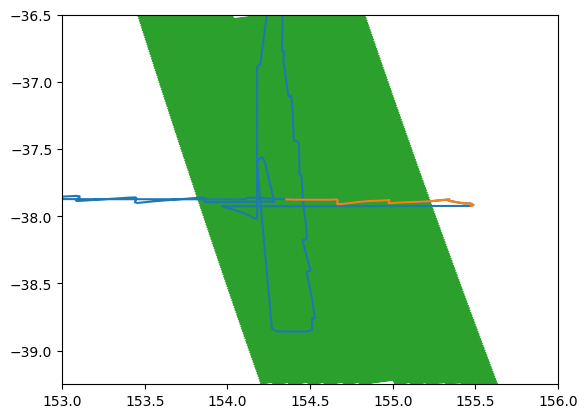

In [190]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

# t3 = pd.Timestamp('2023-10-20 14:00:00') # Good for MOCA
# days3 = .3

t3 = pd.Timestamp('2023-10-20 19:00:00')
days3 = .3

df3 = df_sadcp[(df_sadcp.Time >= t3 - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t3 + pd.Timedelta(days=days3))].copy()
plt.plot(df3.Lon, df3.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

df = df_swot.copy()
df_app1 = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= df3.Time.min()) & (df.Time <= df3.Time.max())]

plt.plot(df_app1.Lon, df_app1.Lat, zorder=-1)
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)

df_app1

(-39.25, -36.5)

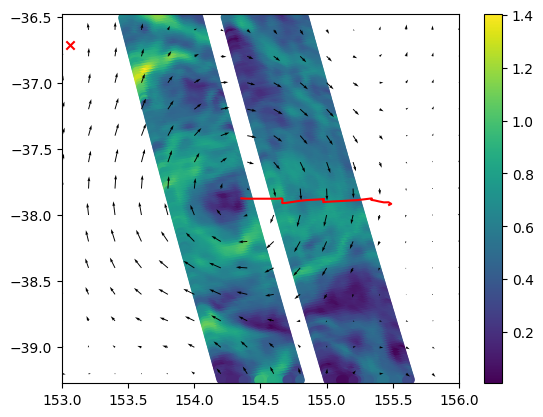

In [191]:
plt.scatter(df_app1.Lon, df_app1.Lat, c=np.hypot(df_app1.u, df_app1.v))
plt.colorbar()

closest = min(tim_ssh, key=lambda t: abs(t - t3))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt)

plt.plot(df3.Lon, df3.Lat, 'r')
xc, yc, w, Q, Rc, psi0 = espra(df3.Lon, df3.Lat, df3.u_37, df3.v_37, Rc_max=1, flag_km=False)
plt.scatter(xc, yc, marker='x', color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=Rc)
plt.plot(x_ell, y_ell, 'r')

plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


### MOCA

In [192]:
def project_sadcp_data(x, y, u, v):

    num_points = len(x)

    df = pd.DataFrame({'x': x, 'y': y, 'u': u, 'v': v})
    df = df.sort_values(by='x').reset_index(drop=True)
    x, y, u, v = np.array(df['x']), np.array(df['y']), np.array(df['u']), np.array(df['v'])

    # Fit a best-fit line (y = m*x + c) using linear regression.
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    # Create a unit direction vector along the best-fit line.
    direction = np.array([1, m])
    direction = direction / np.linalg.norm(direction)
    # Project each (x, y) point onto the line using the first point as reference.
    p0 = np.array([x[0], y[0]])
    points = np.column_stack((x, y))
    projections = np.dot(points - p0, direction)
    # Sort projections and corresponding velocities.
    sort_idx = np.argsort(projections)
    proj_sorted = projections[sort_idx]
    u_sorted = u[sort_idx]
    v_sorted = v[sort_idx]
    # Interpolate the velocity components on evenly spaced positions.
    new_distances = np.linspace(proj_sorted.min(), proj_sorted.max(), num_points)
    new_u = np.interp(new_distances, proj_sorted, u_sorted)
    new_v = np.interp(new_distances, proj_sorted, v_sorted)
    # Calculate new (x, y) points along the line.
    new_points = p0 + np.outer(new_distances, direction)
    # Create and return the output dataframe.
    x, y = new_points[:, 0], new_points[:, 1]

    cos_theta = 1 / np.sqrt(1+m**2)
    sin_theta = m / np.sqrt(1+m**2)
    V_N = -new_u * sin_theta + new_v * cos_theta
    V_T = new_v * sin_theta + new_u * cos_theta
        
    df_projected = pd.DataFrame({
        'x': x,
        'y': y,
        'u': new_u,
        'v': new_v,
        'V_N': V_N,
        'V_T': V_T,
        # 'l': new_distances
    })

    df_projected = df_projected.sort_values(by='x').reset_index(drop=True)

    df_projected['l'] = np.hypot(df_projected['x']-df_projected['x'].iloc[0], df_projected['y']-df_projected['y'].iloc[0])

    return df_projected, m

def translate_MOCA(x_l_start, y_l_start, m, l0, r0):

    x0 = (l0-r0*m)/np.sqrt(1+m**2) + x_l_start
    y0 = (l0*m+r0)/np.sqrt(1+m**2) + y_l_start
    
    return x0, y0


154.3126514483475 -37.96257304148605 -4.429860001112676 [[-1.107465  0.      ]
 [ 0.       -1.107465]] 0.6982730564133636 0.5167136681901323


(-39.25, -36.5)

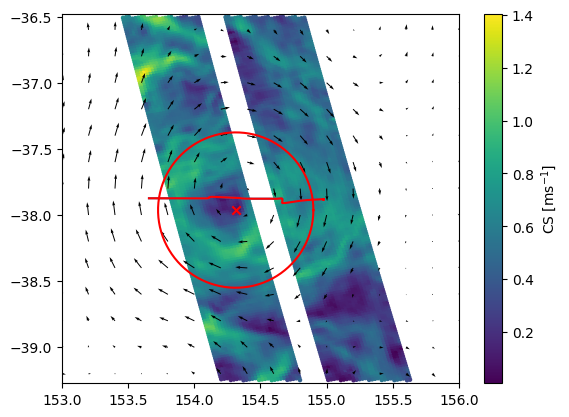

In [193]:
t_moca = pd.Timestamp('2023-10-20 12:00:00')
days3 = .3

df_moca = df_sadcp[(df_sadcp.Time >= t_moca - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t_moca + pd.Timedelta(days=days3))]
plt.plot(df_moca.Lon, df_moca.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

df = df_swot.copy()
df_app_moca = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= df_moca.Time.min()) & (df.Time <= df_moca.Time.max())]

plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=np.hypot(df_app_moca.u, df_app_moca.v), s=5)
plt.colorbar(label=r'CS [ms$^{-1}$]')
closest = min(tim_ssh, key=lambda t: abs(t - t_moca))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)

plt.plot(df_moca.Lon, df_moca.Lat, 'r')

df_projected, m = project_sadcp_data(df_moca.Lon, df_moca.Lat, df_moca.u_37, df_moca.v_37)

l0, r0, w, Q, Rc, psi0 = moca(df_projected.l, df_projected.V_T, df_projected.V_N, Rc_max=1, flag_km=False)
xc, yc = translate_MOCA(df_moca.iloc[0].Lon, df_moca.iloc[0].Lat, m, l0, r0)
print(xc, yc, w, Q, Rc, psi0)

plt.scatter(xc, yc, marker='x', color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=Rc)
plt.plot(x_ell, y_ell, 'r')

plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


(np.float64(152.85),
 np.float64(156.15),
 np.float64(-39.3875),
 np.float64(-36.3625))

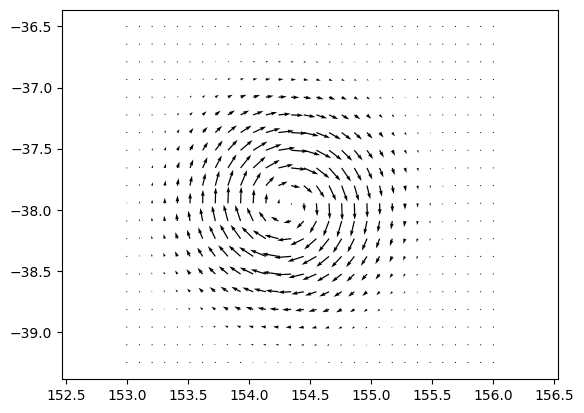

In [194]:
x, y = np.linspace(lon0, lon1, 30), np.linspace(lat0, lat1, 20)
X, Y = np.meshgrid(x, y)

u, v, *_ = gaussian_vel_reconstruction(xc, yc, Q[0,0], Q[1,0], Q[1,1], Rc, psi0, X=X, Y=Y)
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')


Interpolate what my reconstructed u and v are at the SWOT points and compare

In [ ]:
from scipy.interpolate import griddata

pts = np.stack((X.ravel(), Y.ravel()), axis=-1)
u_vals = u.ravel()
v_vals = v.ravel()

u_moc, v_moc = [], []
for k in range(len(df_app_moca)):
    data = df_app_moca.iloc[k]
    xp, yp = data.Lon, data.Lat
    
    u_moc.append(griddata(pts, u_vals, (xp, yp), method='linear'))
    v_moc.append(griddata(pts, v_vals, (xp, yp), method='linear'))
    
df_app_moca['u_moca'] = u_moc
df_app_moca['u_moca']= df_app_moca['u_moca'].astype(float)
df_app_moca['v_moca'] = v_moc
df_app_moca['v_moca']= df_app_moca['v_moca'].astype(float)

df_app_moca.loc[:, 'u_err'] = np.abs(df_app_moca.u - df_app_moca.u_moca)
df_app_moca.loc[:, 'v_err'] = np.abs(df_app_moca.v - df_app_moca.v_moca)

speed_obs = np.hypot(df_app_moca.u, df_app_moca.v)
speed_mod = np.hypot(df_app_moca.u_moca, df_app_moca.v_moca)

df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod) / speed_obs

# df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod)


In [ ]:
df_app_moca.head()


In [ ]:
plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=df_app_moca.err, cmap='RdYlGn_r', vmin=0, vmax=.6)
plt.colorbar(label=r'Error [ms$^{-1}$]')
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc1 = ax1.scatter(
    df_app_moca.Lon,
    df_app_moca.Lat,
    c=np.hypot(df_app_moca.u, df_app_moca.v),
    vmin=0,
    s=7,
    label='SWOT Data'
)
fig.colorbar(sc1, ax=ax1, label=r'CS [ms$^{-1}$]')
ax1.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)
ax1.plot(df_moca.Lon, df_moca.Lat, 'm', linewidth=2, label='Ship Track')
ax1.scatter(xc, yc, marker='x', color='r', s=50, label='Eddy Center')
ax1.plot(x_ell, y_ell, 'r', linewidth=2, label='Core Radius')
ax1.set_aspect('equal')
ax1.set_xlim(lon0, lon1)
ax1.set_ylim(lat0, lat1)
ax1.set_title('Original Sampling')
ax1.set_xlabel('Longitude (°E)')
ax1.set_ylabel('Latitude (°N)')

from matplotlib.lines import Line2D
handles, labels = ax1.get_legend_handles_labels()
arrow_handle = Line2D([0], [0], color='k', lw=0, marker=r'$\rightarrow$', markersize=10, label='IMOS data')
handles.append(arrow_handle)
ax1.legend(handles=handles, loc='upper right')

sc2 = ax2.scatter(
    df_app_moca.Lon,
    df_app_moca.Lat,
    c=df_app_moca.err,
    cmap='RdYlGn_r',
    vmin=0,
    vmax=.4,
    s=7
)
fig.colorbar(sc2, ax=ax2, label=r'Error [ms$^{-1}$]')
ax2.quiver(X, Y, u, v, scale=20, width=.0025, color='b')
ax2.scatter(xc, yc, marker='x', color='b', s=50, label='Eddy Center')
ax2.plot(x_ell, y_ell, 'b', linewidth=2, label='Core Radius')
ax2.set_aspect('equal')
ax2.set_xlim(lon0, lon1)
ax2.set_ylim(lat0, lat1)
ax2.set_title('MOCA Reconstruction')
ax2.set_xlabel('Longitude (°E)')
ax2.set_ylabel('Latitude (°N)')

handles, labels = ax2.get_legend_handles_labels()
arrow_handle = Line2D([0], [0], color='b', lw=0, marker=r'$\rightarrow$', markersize=10, label='MOCA\n Reconstructed\n data')
handles.append(arrow_handle)
ax2.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.show()
